In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201, Xception, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

2025-08-11 08:32:44.932589: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-11 08:32:45.185271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754901165.275801    1991 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754901165.305136    1991 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754901165.525455    1991 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# Path to your single dataset folder (should have subfolders for each class)
data_dir = '/teamspace/studios/this_studio/Hibiscus and Tea  combined Dataset'  # e.g., 'vegetable_dataset/'

# Parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)  # DenseNet121 default input size
NUM_CLASSES = 8
EPOCHS = 20
VAL_SPLIT = 0.15  # 20% for validation
TEST_SPLIT = 0.15  # 10% for testing

In [4]:
# Step 2: Load and preprocess dataset with progress bar
def load_dataset(data_dir):
    images = []
    labels = []

    for class_idx, class_name in enumerate(CLASS_NAMES):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: Directory {class_dir} not found!")
            continue

        print(f"Loading {class_name} images...")
        for img_file in tqdm(os.listdir(class_dir)):
            img_path = os.path.join(class_dir, img_file)
            try:
                with Image.open(img_path) as img:
                    img = img.convert('RGB')  # Ensure RGB format
                    img = img.resize(IMAGE_SIZE)
                    img_array = np.array(img) / 255.0
                    if img_array.shape == (*IMAGE_SIZE, 3):
                        images.append(img_array)
                        labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels)

In [5]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator

IMG_SIZE = (224, 224)
TARGET_PER_CLASS = 1000  # 3x from 500 original images

# 🏷️ Class names
class_names = sorted(os.listdir(data_dir))
NUM_CLASSES = len(class_names)
print("Classes:", class_names)

# 🎛️ Data Augmentation Setup
aug_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# 🖼️ Load images and apply augmentation
all_images = []
all_labels = []

for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    img_names = os.listdir(class_path)
    img_paths = [os.path.join(class_path, img) for img in img_names]

    # Load original images
    original_images = []
    for img_path in img_paths:
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
        original_images.append(img_array)

    # Add original images
    all_images.extend(original_images)
    all_labels.extend([class_idx] * len(original_images))

    # Number of augmented images to generate
    num_to_generate = TARGET_PER_CLASS - len(original_images)
    print(f"{class_name}: Generating {num_to_generate} augmented images")

    i = 0
    while i < num_to_generate:
        img = random.choice(original_images)
        img = np.expand_dims(img, axis=0)
        for batch in aug_gen.flow(img, batch_size=1):
            all_images.append(batch[0])
            all_labels.append(class_idx)
            i += 1
            if i >= num_to_generate:
                break

# 🔀 Final dataset
X = np.array(all_images)
y = np.array(all_labels)
print(f"\n✅ Total images after augmentation: {X.shape[0]}")
print("Class distribution:", Counter(y))

# 🔀 Split: 15% test, then 15% val, rest train
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

# 📦 TF Datasets
def create_dataset(X, y):
    return tf.data.Dataset.from_tensor_slices((X, tf.one_hot(y, depth=NUM_CLASSES)))

train_ds = create_dataset(X_train, y_train).shuffle(1000).batch(BATCH_SIZE)
val_ds = create_dataset(X_val, y_val).batch(BATCH_SIZE)
test_ds = create_dataset(X_test, y_test).batch(BATCH_SIZE)

# 🧾 Summary
print("\n✅ Final dataset shapes:")
print("Train:", X_train.shape, " | ", Counter(y_train))
print("Val  :", X_val.shape, " | ", Counter(y_val))
print("Test :", X_test.shape, " | ", Counter(y_test))


Classes: ['Brown Blight', 'Early_Mild_Spotting', 'Fungal_Infected', 'Grey Blight', 'Mild_Edge_Damage', 'Senescent', 'Slightly_Diseased', 'Wrinkled_Leaf']


Brown Blight: Generating 952 augmented images
Early_Mild_Spotting: Generating 0 augmented images
Fungal_Infected: Generating 0 augmented images
Grey Blight: Generating 947 augmented images
Mild_Edge_Damage: Generating 0 augmented images
Senescent: Generating 0 augmented images
Slightly_Diseased: Generating 0 augmented images
Wrinkled_Leaf: Generating 6 augmented images

✅ Total images after augmentation: 8000
Class distribution: Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000})


I0000 00:00:1754901286.072082    1991 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:04.0, compute capability: 8.9



✅ Final dataset shapes:
Train: (5599, 224, 224, 3)  |  Counter({5: 700, 7: 700, 4: 700, 1: 700, 2: 700, 3: 700, 0: 700, 6: 699})
Val  : (1201, 224, 224, 3)  |  Counter({6: 151, 1: 150, 7: 150, 0: 150, 5: 150, 4: 150, 3: 150, 2: 150})
Test : (1200, 224, 224, 3)  |  Counter({7: 150, 5: 150, 0: 150, 2: 150, 1: 150, 3: 150, 4: 150, 6: 150})


In [7]:
from tensorflow.keras.applications import DenseNet201, InceptionV3, Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Average, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Constants
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 8  # Adjust according to your dataset

def create_individual_model(base_model_class, dropout_rate=0.2):
    """Helper function to create individual models with consistent architecture"""
    base_model = base_model_class(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)
    base_model.trainable = True
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    
    return Model(inputs=base_model.input, outputs=predictions)

def build_ensemble():
    """Build the ensemble model combining all three models"""
    # Create individual models
    densenet = create_individual_model(DenseNet201, dropout_rate=0.2)
    inception = create_individual_model(InceptionV3, dropout_rate=0.5)
    xception = create_individual_model(Xception, dropout_rate=0.3)
    
    # Give them identifiable names
    densenet._name = 'densenet'
    inception._name = 'inception'
    xception._name = 'xception'
    
    # Create separate input layers for each model
    input_densenet = Input(shape=INPUT_SHAPE, name='input_densenet')
    input_inception = Input(shape=INPUT_SHAPE, name='input_inception')
    input_xception = Input(shape=INPUT_SHAPE, name='input_xception')
    
    # Get individual predictions
    pred_densenet = densenet(input_densenet)
    pred_inception = inception(input_inception)
    pred_xception = xception(input_xception)
    
    # Weighted average based on validation accuracies
    weights = {
        'densenet': 0.34,    # DenseNet201 98.00%
        'inception': 0.339,  # InceptionV3 97.92%
        'xception': 0.321    # Xception 95.00%
    }
    
    # Weighted predictions using Keras Lambda layer
    weighted_densenet = Lambda(lambda x: x * weights['densenet'])(pred_densenet)
    weighted_inception = Lambda(lambda x: x * weights['inception'])(pred_inception)
    weighted_xception = Lambda(lambda x: x * weights['xception'])(pred_xception)
    
    weighted_avg = Average()([weighted_densenet, weighted_inception, weighted_xception])
    
    # Create ensemble model
    ensemble_model = Model(
        inputs=[input_densenet, input_inception, input_xception],
        outputs=weighted_avg,
        name='top3_ensemble'
    )
    
    return ensemble_model, [densenet, inception, xception]

def compile_ensemble(ensemble_model):
    """Compile the ensemble model"""
    ensemble_model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

# Create and compile the ensemble
ensemble_model, individual_models = build_ensemble()
compile_ensemble(ensemble_model)

# Print model summary
ensemble_model.summary()


Model: "top3_ensemble"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_densenet      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_inception     │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_xception      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 8)         │ 19,309,640 │ input_densenet[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 8)         │ 22,855,976 │ input_inception[… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 8)         │ 21,914,672 │ input_xception[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 8)         │          0 │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 8)         │          0 │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 8)         │          0 │ functional_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average (Average)   │ (None, 8)         │          0 │ lambda[0][0],     │
│                     │                   │            │ lambda_1[0][0],   │
│                     │                   │            │ lambda_2[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 64,080,288 (244.45 MB)

 Trainable params: 63,762,272 (243.23 MB)

 Non-trainable params: 318,016 (1.21 MB)

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Adapt dataset to provide 3 identical inputs for the ensemble
def adapt_for_ensemble(ds):
    return ds.map(lambda x, y: ((x, x, x), y))

# Adapt train and val datasets
train_ds_ensemble = adapt_for_ensemble(train_ds)
val_ds_ensemble = adapt_for_ensemble(val_ds)

# Define model name
model_name = "top3_ensemble"

# Callbacks
checkpoint = ModelCheckpoint(
    f"{model_name}.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-4,
    verbose=1
)

# Compile the ensemble model (if not already compiled)
ensemble_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Train the ensemble model
history = ensemble_model.fit(
    train_ds_ensemble,
    validation_data=val_ds_ensemble,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Epoch 1/20


I0000 00:00:1754901445.540369    3738 service.cc:152] XLA service 0x7284cc001f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754901445.540767    3738 service.cc:160]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-08-11 08:37:31.661230: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754901477.339528    3738 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-08-11 08:38:17.718441: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96957_0', 32 bytes spill stores, 32 bytes spill loads

2025-08-11 08:38:17.990820: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96957', 40 bytes

174/175 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.7571 - loss: 0.7735 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00

2025-08-11 08:50:13.452142: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96957_0', 20 bytes spill stores, 20 bytes spill loads

2025-08-11 08:50:13.745783: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96957', 500 bytes spill stores, 500 bytes spill loads

2025-08-11 08:50:13.746365: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96957', 44 bytes spill stores, 44 bytes spill loads

2025-08-11 08:50:13.836762: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96957', 44 bytes spill stores, 44 bytes spill loads

2025-08-11 08:50:15.335201: I ex

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7578 - loss: 0.7714 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00   

2025-08-11 08:59:59.424392: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8966', 4 bytes spill stores, 4 bytes spill loads

2025-08-11 08:59:59.770798: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8966', 4 bytes spill stores, 4 bytes spill loads

2025-08-11 09:00:33.939170: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8959_0', 20 bytes spill stores, 20 bytes spill loads

2025-08-11 09:00:34.268339: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8959', 500 bytes spill stores, 500 bytes spill loads

2025-08-11 09:00:35.016910: I external/l


Epoch 1: val_accuracy improved from -inf to 0.93505, saving model to top3_ensemble.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 1574s 5s/step - accuracy: 0.7584 - loss: 0.7694 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9351 - val_loss: 0.1945 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9744 - loss: 0.1013 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 2: val_accuracy improved from 0.93505 to 0.96586, saving model to top3_ensemble.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 98s 561ms/step - accuracy: 0.9744 - loss: 0.1012 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9659 - val_loss: 0.1089 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9930 - loss: 0.0481 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 3: val_accuracy did not improve from 0.96586
175/175 ━━━━━━━━━━━━━━━━━━━━ 93s 529ms/step - accuracy: 0.9930 - loss: 0.0481 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9550 - val_loss: 0.1011 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.9960 - loss: 0.0328 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 4: val_accuracy improved from 0.96586 to 0.97336, saving model to top3_ensemble.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 98s 559ms/step - accuracy: 0.9960 - loss: 0.0328 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9734 - val_loss: 0.0827 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.9956 - loss: 0.0301 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 5: val_accuracy improved from 0.97336 to 0.98335, saving model to top3_ensemble.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 100s 569ms/step - accuracy: 0.9956 - loss: 0.0300 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9833 - val_loss: 0.0472 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.9967 - loss: 0.0213 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 6: val_accuracy did not improve from 0.98335
175/175 ━━━━━━━━━━━━━━━━━━━━ 93s 529ms/step - accuracy: 0.9967 - loss: 0.0213 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9825 - val_loss: 0.0589 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.9955 - loss: 0.0271 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 7: val_accuracy did not improve from 0.98335
175/175 ━━━━━━━━━━━━━━━━━━━━ 92s 528ms/step - accuracy: 0.9955 - loss: 0.0271 - precision_1: 0.0000e+00 - recall_1:

175/175 ━━━━━━━━━━━━━━━━━━━━ 97s 554ms/step - accuracy: 0.9984 - loss: 0.0192 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9883 - val_loss: 0.1233 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 12/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.9973 - loss: 0.0240 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 12: val_accuracy did not improve from 0.98834
175/175 ━━━━━━━━━━━━━━━━━━━━ 93s 529ms/step - accuracy: 0.9973 - loss: 0.0240 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9833 - val_loss: 0.0989 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 13/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.9973 - loss: 0.0205 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 13: val_accuracy did not improve from 0.98834
175/175 ━━━━━━━━━━━━━━━━━━━━ 92s 529ms/step - accuracy: 0.9973 - loss: 0.0205 - precision_1: 0.0000e+00 - recall

In [9]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.


37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step

2025-08-11 09:24:19.119780: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8892', 264 bytes spill stores, 264 bytes spill loads

2025-08-11 09:24:19.667998: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8892', 40 bytes spill stores, 40 bytes spill loads

2025-08-11 09:24:19.910964: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8899', 12 bytes spill stores, 12 bytes spill loads

2025-08-11 09:24:20.256060: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8892', 5008 bytes spill stores, 5004 bytes spill loads

2025-08-11 09:24:20.538805: I exte

38/38 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step 


2025-08-11 09:24:55.277071: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification Report:

                     precision    recall  f1-score   support

       Brown Blight       0.99      0.98      0.99       150
Early_Mild_Spotting       0.91      0.97      0.94       150
    Fungal_Infected       1.00      0.99      0.99       150
        Grey Blight       0.98      0.99      0.99       150
   Mild_Edge_Damage       0.99      0.99      0.99       150
          Senescent       1.00      1.00      1.00       150
  Slightly_Diseased       0.98      0.91      0.94       150
      Wrinkled_Leaf       0.99      1.00      1.00       150

           accuracy                           0.98      1200
          macro avg       0.98      0.98      0.98      1200
       weighted avg       0.98      0.98      0.98      1200


Confusion matrix, without normalization


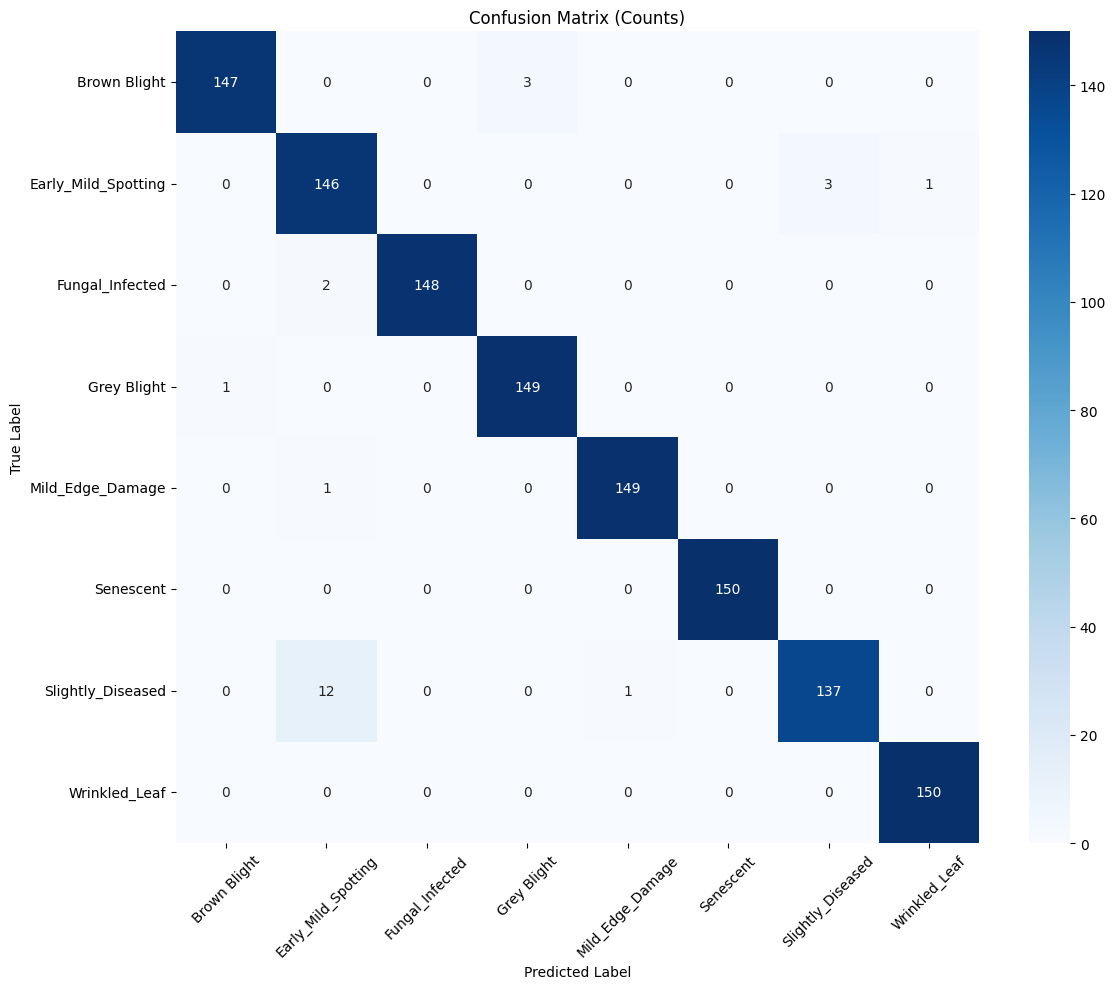


Normalized confusion matrix


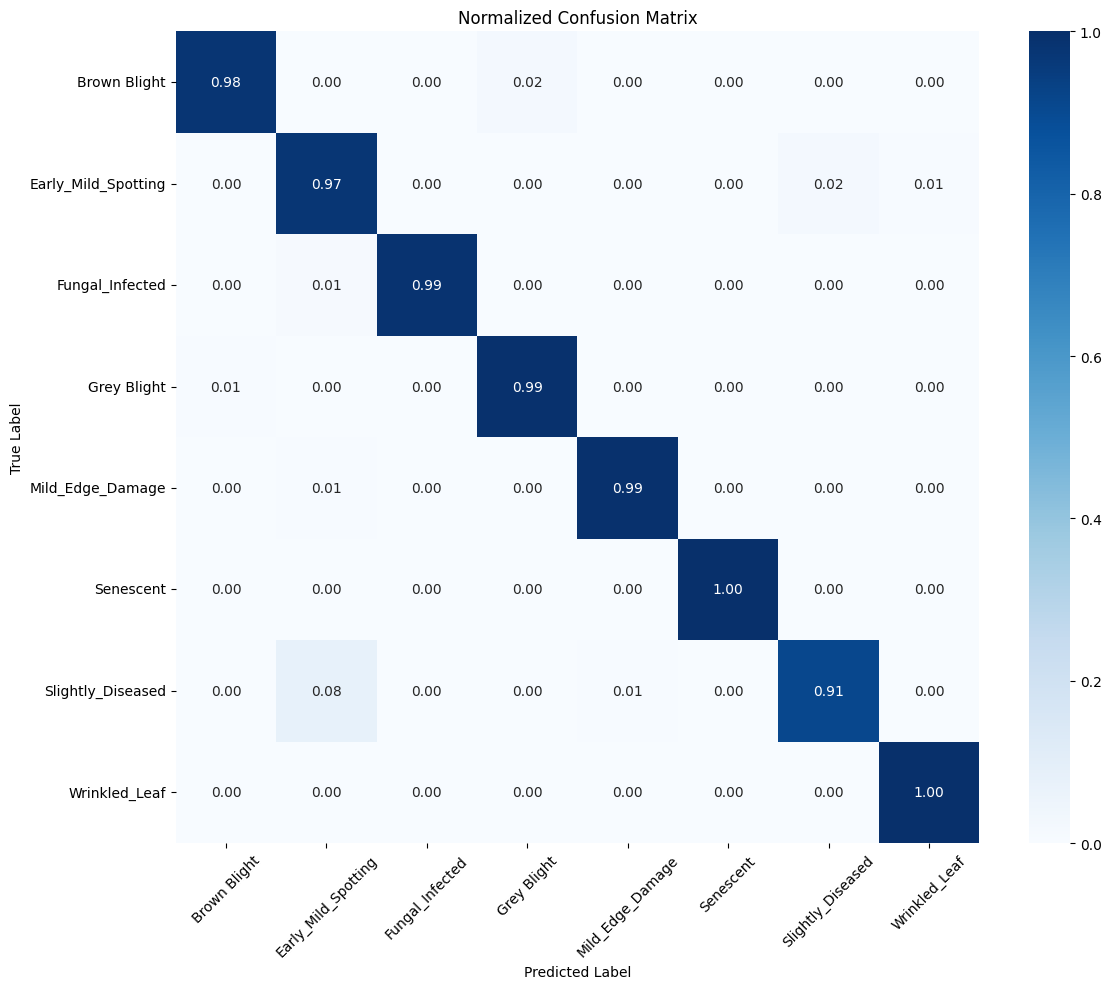

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Ensemble expects 3 inputs, so we must pass (x, x, x)
def prepare_test_for_prediction(ds):
    return ds.map(lambda x, y: ((x, x, x), y))

# 🧪 Prepare test dataset for prediction
test_ds_ens = prepare_test_for_prediction(test_ds)

# 🔍 Predict
y_pred_probs = ensemble_model.predict(test_ds_ens)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 🎯 Extract true labels
y_true = []
for _, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)

# 🧾 Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# 📊 Confusion matrix plotting function
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        print("\nNormalized confusion matrix")
    else:
        print("\nConfusion matrix, without normalization")

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 🖼️ Plot both confusion matrices
plot_confusion_matrix(y_true, y_pred_classes, classes=class_names, title='Confusion Matrix (Counts)')
plot_confusion_matrix(y_true, y_pred_classes, classes=class_names, normalize=True, title='Normalized Confusion Matrix')


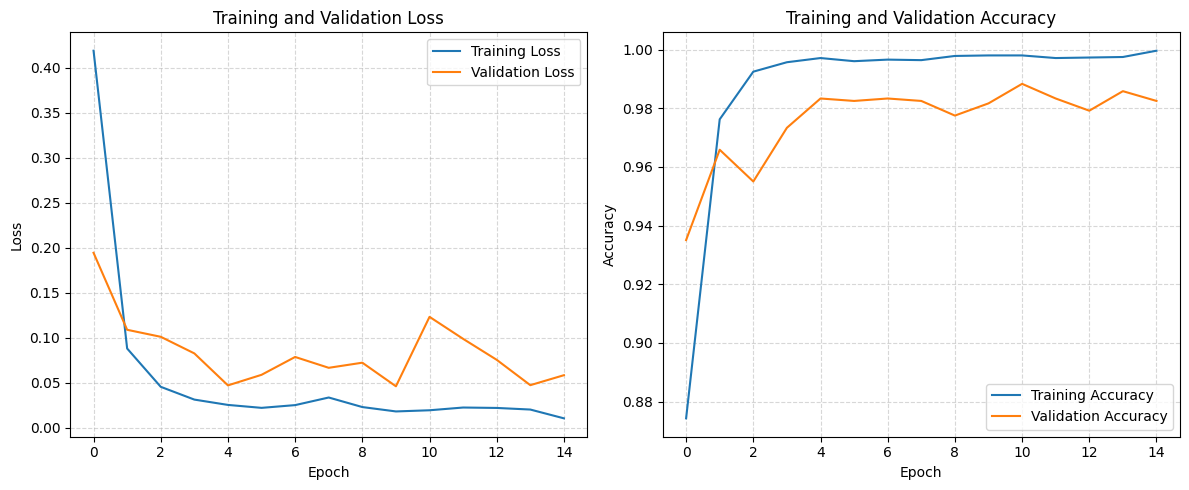


📉 Best Validation Loss: 0.0461 at epoch 10
   Training Loss at that epoch: 0.0182
   Validation Accuracy at that epoch: 0.9817


In [11]:
import matplotlib.pyplot as plt
import numpy as np  # Ensure numpy is imported

# ✅ Make sure to pass the correct 'history' object from model.fit()
# Example: history = train_ensemble(ensemble_model, train_ds, val_ds, epochs=...)
history_dict = history.history

# 📊 Create figure with two subplots
plt.figure(figsize=(12, 5))

# 1️⃣ Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# 2️⃣ Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 🏆 Optional: Print best validation loss & related info
best_val_epoch = np.argmin(history_dict['val_loss'])
print(f"\n📉 Best Validation Loss: {history_dict['val_loss'][best_val_epoch]:.4f} at epoch {best_val_epoch + 1}")
print(f"   Training Loss at that epoch: {history_dict['loss'][best_val_epoch]:.4f}")
print(f"   Validation Accuracy at that epoch: {history_dict['val_accuracy'][best_val_epoch]:.4f}")


 5/38 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step


2025-08-11 09:25:01.806015: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


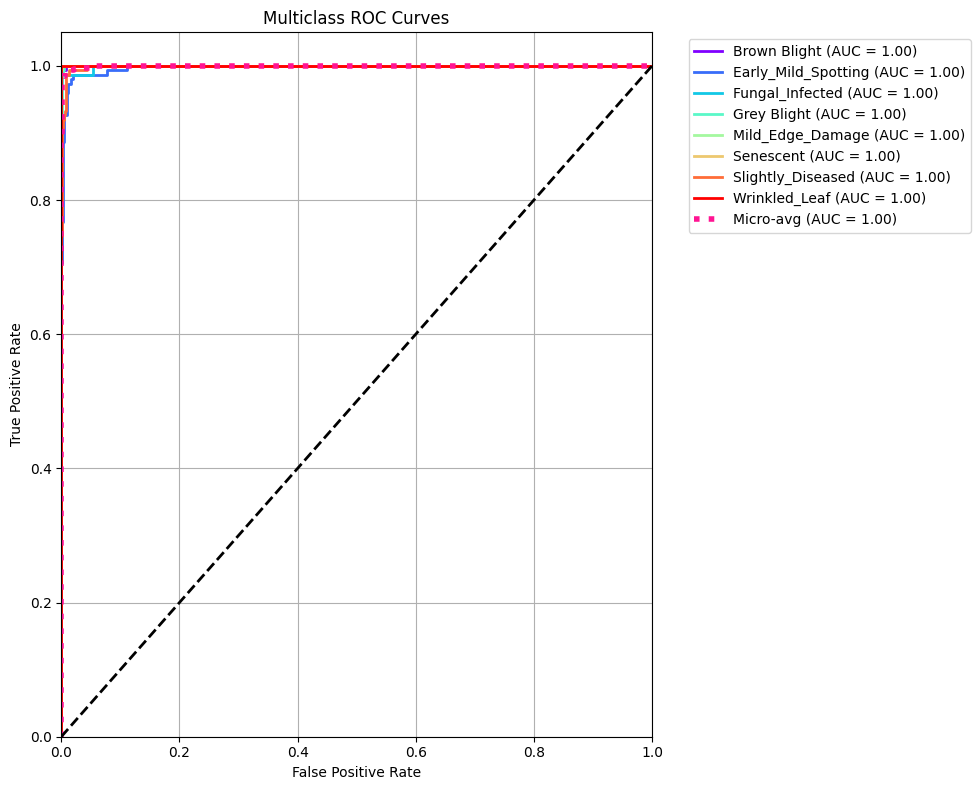


📊 AUC Scores:
Brown Blight: 0.9999
Early_Mild_Spotting: 0.9974
Fungal_Infected: 0.9993
Grey Blight: 0.9999
Mild_Edge_Damage: 1.0000
Senescent: 1.0000
Slightly_Diseased: 0.9989
Wrinkled_Leaf: 1.0000

Micro-average AUC: 0.9996


In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

# ✅ Step 1: Prepare test dataset for ensemble model (x, x, x)
def prepare_test_for_prediction(ds):
    return ds.map(lambda x, y: ((x, x, x), y))

test_ds_ens = prepare_test_for_prediction(test_ds)

# ✅ Step 2: Get predictions from model
y_pred = ensemble_model.predict(test_ds_ens)

# ✅ Step 3: Get true labels from one-hot encoded test set
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_true_labels = np.argmax(y_true, axis=1)  # Convert one-hot to labels

# ✅ Step 4: Binarize the true labels for ROC
y_true_bin = label_binarize(y_true_labels, classes=np.arange(NUM_CLASSES))

# ✅ Step 5: Compute ROC curves and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ✅ Step 6: Compute micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ✅ Step 7: Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(plt.cm.rainbow(np.linspace(0, 1, NUM_CLASSES)))

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:0.2f})')

# Micro-average curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-avg (AUC = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Final plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Step 8: Print AUC scores
print("\n📊 AUC Scores:")
for i in range(NUM_CLASSES):
    print(f"{class_names[i]}: {roc_auc[i]:.4f}")
print(f"\nMicro-average AUC: {roc_auc['micro']:.4f}")


 4/38 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step


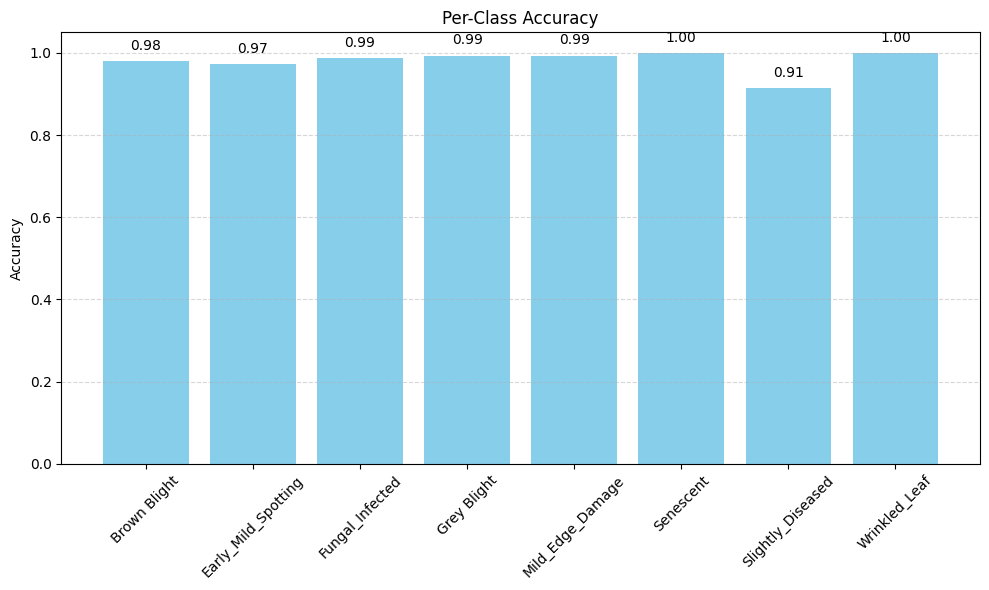

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from collections import defaultdict

# ✅ Step 1: Prepare test data for ensemble
def prepare_test_for_prediction(ds):
    return ds.map(lambda x, y: ((x, x, x), y))

test_ds_ens = prepare_test_for_prediction(test_ds)

# ✅ Step 2: Get model predictions
y_pred_probs = ensemble_model.predict(test_ds_ens)
y_pred = np.argmax(y_pred_probs, axis=1)

# ✅ Step 3: Extract true labels
y_true = []
for _, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)

# ✅ Step 4: Compute per-class accuracy
class_correct = defaultdict(int)
class_total = defaultdict(int)

for true, pred in zip(y_true, y_pred):
    class_total[true] += 1
    if true == pred:
        class_correct[true] += 1

per_class_acc = {
    class_names[i]: class_correct[i] / class_total[i]
    for i in range(NUM_CLASSES)
}

# ✅ Step 5: Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(per_class_acc.keys(), per_class_acc.values(), color='skyblue')
plt.ylim([0, 1.05])
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.02, f'{height:.2f}', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [14]:
!pip install umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 77.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 108.3 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 141.9 MB/s  0:00:00
  Attempting uninstall: scikit-learn━━━━━━━━━━━━ 0/5 [llvmlite]
    Found existing installation: scikit-learn 1.3.232m0/5 [llvmlite]
    Uninstalling scikit-learn-1.3.2:━━━━━━━━ 0/5 [llvmlite]
      Successfully uninstalled scikit-learn-1.3.2━━━━━━━━━━━━━━━━━ 1/5 [scikit-learn]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [umap-learn]5 [numba]-learn]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.1 which is incompatible.


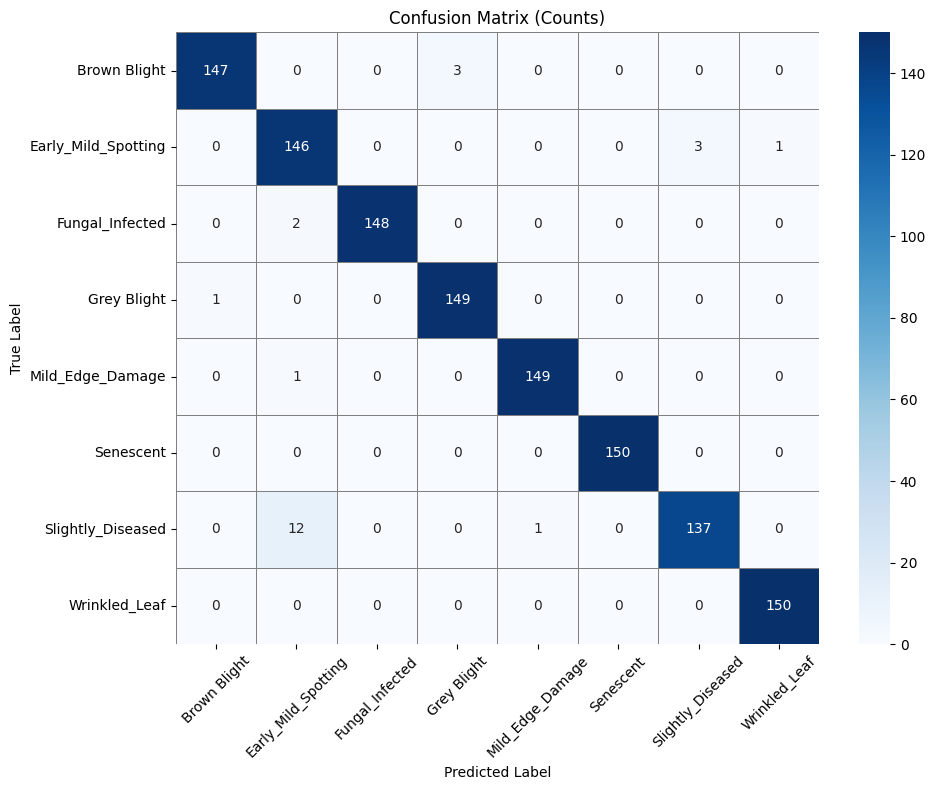

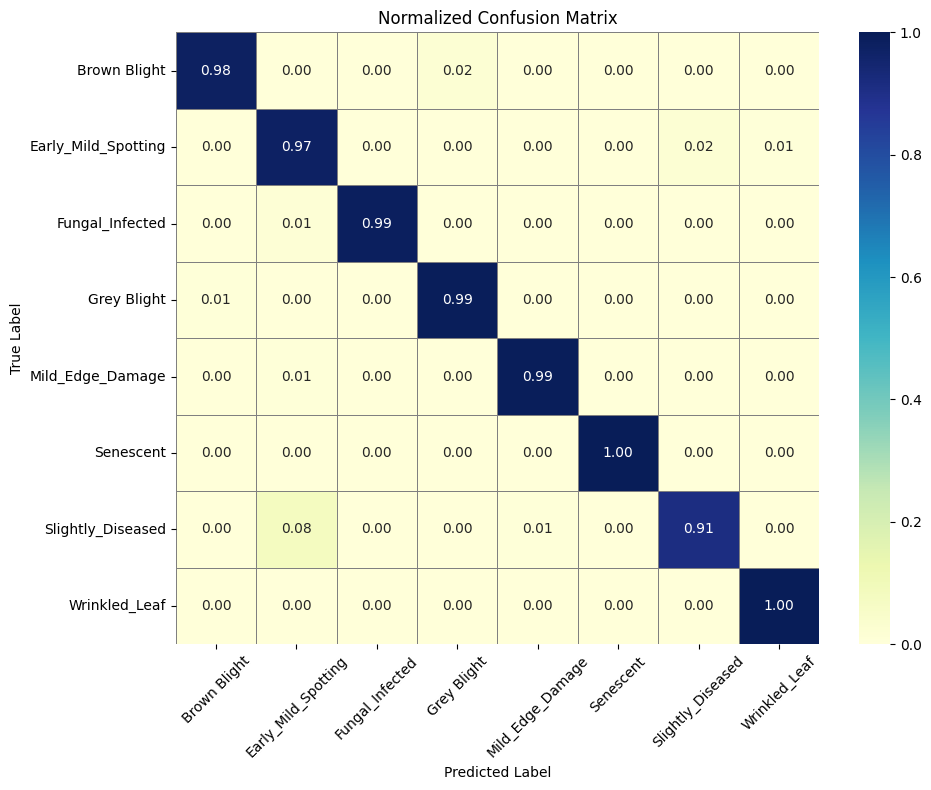

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_and_save_confusion_heatmap(y_true, y_pred, class_names, normalize=False,
                                     title="Confusion Matrix Heatmap", filename="confusion_heatmap.png"):
    """
    Plot and save a confusion matrix heatmap.

    Args:
        y_true: Array of ground truth labels
        y_pred: Array of predicted labels
        class_names: List of class names
        normalize: If True, normalize the matrix
        title: Title of the plot
        filename: Output filename to save the image
    """
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = ".2f"
        cmap = "YlGnBu"
    else:
        fmt = "d"
        cmap = "Blues"

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=class_names,
                yticklabels=class_names,
                linewidths=0.5, linecolor='gray')

    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # ✅ Save heatmap as image
    plt.savefig(filename, dpi=300)
    plt.show()

# ✅ Example usage
plot_and_save_confusion_heatmap(
    y_true=y_true,
    y_pred=y_pred_classes,
    class_names=class_names,
    normalize=False,
    title="Confusion Matrix (Counts)",
    filename="confusion_matrix_counts.png"
)

plot_and_save_confusion_heatmap(
    y_true=y_true,
    y_pred=y_pred_classes,
    class_names=class_names,
    normalize=True,
    title="Normalized Confusion Matrix",
    filename="confusion_matrix_normalized.png"
)


In [19]:
pip install lime

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 133.2 MB/s  0:00:00
  DEPRECATION: Building 'lime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lime'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283913 sha256=5b304a198faf76b1b8a7e8a87fa157a1d4a776301c81e22b484c9852efc4cc3f
  Stored in directory: /home/zeus/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [lime]2/4 [scikit-image]
Note: you may need to restart the kernel to use updated packages.


In [23]:
conda install -y -c conda-forge numpy=1.23.5 scipy=1.10 scikit-learn=1.3.2  # via pip; conda packages for lime are spotty


/home/zeus/miniconda3/lib/python3.10/site-packages/conda/base/context.py:211: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.9. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(


Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.5.1
    latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/zeus/miniconda3/envs/cloudspace

  added / updated specs:
    - numpy=1.23.5
    - scikit-learn=1.3.2
    - scipy=1.10


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotli-python-1.1.0        |  py310hf71b8c6_3         343 KB  conda-forge
    ca-certificates-2025.8.3   |       hbd8a1cb_0         151 KB  conda-forge
    certifi-2025.8.3           |     pyhd8ed1ab_0         155 KB  conda-forge
    cffi-1.17.1                |  py310h8deb56e_0         238 KB  conda-forge
    charset-normalizer-3.4.3   |     pyhd8ed1ab_0          50 KB  conda-forge
    expat-2.7.1          

In [24]:
pip install -U "lime==0.2.0.1"  # via pip; conda packages for lime are spotty


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 128.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 174.9 MB/s  0:00:00m0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5━━━━━ 0/2 [numpy]
  Attempting uninstall: scipy━━━━━━━━━━━━━━━━━━━ 0/2 [numpy]
    Found existing installation: scipy 1.10.1 0/2 [numpy]
    Uninstalling scipy-1.10.1:━━━━━━━━━━━━━━ 0/2 [numpy]
      Successfully uninstalled scipy-1.10.1━━━━━━━━━━━━━━━━━━━ 1/2 [scipy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [scipy]32m1/2 [scipy]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.3.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import tensorflow as tf


In [35]:
# --- Step 1: Wrap test dataset (unchanged) ---
def prepare_test_for_ensemble(ds):
    return ds.map(lambda x, y: ((x, x, x), y))

test_ds_ensemble = prepare_test_for_ensemble(test_ds)

In [36]:
# --- Step 2: LIME prediction fn (handles preprocessing & softmax) ---
def ensemble_predict(images: np.ndarray) -> np.ndarray:
    """
    images: (N,H,W,C) uint8 or float; returns (N, NUM_CLASSES) probabilities
    """
    # Ensure float32 in 0..1
    if images.dtype != np.float32:
        images = images.astype(np.float32)
    if images.max() > 1.0:  # coming from uint8 [0..255]
        images = images / 255.0

    # If your model needs a specific input size, resize here with tf.image.resize

    # Model expects three identical inputs
    preds = ensemble_model.predict([images, images, images], verbose=0)

    # Ensure probabilities
    if preds.shape[-1] == 1:
        # Binary model returning sigmoid or logit
        if preds.min() < 0 or preds.max() > 1:
            preds = tf.math.sigmoid(preds).numpy()
        probs_pos = preds
        preds = np.concatenate([1.0 - probs_pos, probs_pos], axis=-1)
    else:
        # Multiclass: make sure they’re probs
        if preds.min() < 0 or preds.max() > 1:
            preds = tf.nn.softmax(preds, axis=-1).numpy()
    return preds

In [37]:
# --- Step 3: Sample one image ---
for (batch_x1, batch_x2, batch_x3), batch_y in test_ds_ensemble.take(1):
    img = batch_x1[10].numpy()  # (H,W,C), float 0..1 usually
    true_label = int(np.argmax(batch_y[10].numpy()))
    break

# --- Step 4: LIME explainer ---
explainer = lime_image.LimeImageExplainer()

# --- Step 5: LIME expects standard images; keep uint8 and let classifier_fn scale ---
img_uint8 = (img * 255).astype(np.uint8)

# --- Step 6: Explain ---
NUM_CLASSES = len(class_names)  # ensure this is defined
explanation = explainer.explain_instance(
    img_uint8,
    classifier_fn=ensemble_predict,   # must accept (N,H,W,C) and return probs
    top_labels=NUM_CLASSES,
    hide_color=0,
    num_samples=500
)

  0%|          | 0/500 [00:00<?, ?it/s]

In [32]:

# --- Step 7: Predicted label using same preprocessing path ---
predicted_label = int(np.argmax(ensemble_predict(img_uint8[np.newaxis, ...])))

# --- Step 8: Visualization mask ---
temp, mask = explanation.get_image_and_mask(
    label=predicted_label,
    positive_only=True,
    hide_rest=False,
    num_features=8,
    min_weight=0.0
)

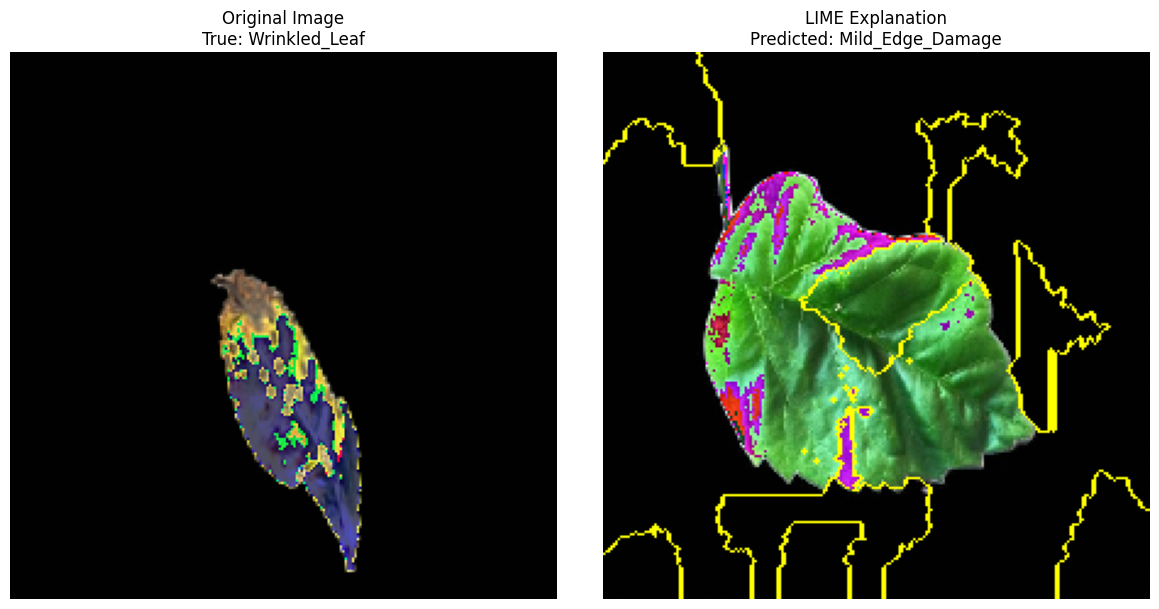

In [39]:
# --- Step 9: Plot ---
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img_uint8)
ax[0].set_title(f"Original Image\nTrue: {class_names[true_label]}")
ax[0].axis('off')

ax[1].imshow(mark_boundaries(temp, mask))
ax[1].set_title(f"LIME Explanation\nPredicted: {class_names[predicted_label]}")
ax[1].axis('off')

plt.tight_layout()
plt.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import tensorflow as tf

# Step 1: Wrap your test dataset to provide 3 identical inputs per sample
def prepare_test_for_ensemble(ds):
    return ds.map(lambda x, y: ((x, x, x), y))

test_ds_ensemble = prepare_test_for_ensemble(test_ds)

# Step 2: Define a prediction function for LIME (takes single image or batch)
def ensemble_predict(images):
    """
    images: numpy array of shape (N, H, W, C)
    Returns: numpy array of shape (N, NUM_CLASSES)
    """
    inputs = [images, images, images]  # replicate input for ensemble
    preds = ensemble_model.predict(inputs)
    return preds

# Step 3: Take one image from the wrapped test dataset for explanation
for (batch_x1, batch_x2, batch_x3), batch_y in test_ds_ensemble.take(1):
    img = batch_x1[0].numpy()  # First image in batch, shape (224,224,3)
    true_label = np.argmax(batch_y[0].numpy())
    break

# Step 4: Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Step 5: Prepare image for LIME (uint8 and scaled 0-255)
img_uint8 = (img * 255).astype(np.uint8)

# Step 6: Generate explanation
explanation = explainer.explain_instance(
    img_uint8,
    classifier_fn=ensemble_predict,
    top_labels=NUM_CLASSES,
    hide_color=0,
    num_samples=1000
)

# Step 7: Get predicted label from the model for this image
predicted_label = np.argmax(ensemble_predict(img[np.newaxis, ...]))

# Step 8: Get image and mask highlighting important regions
temp, mask = explanation.get_image_and_mask(
    label=predicted_label,
    positive_only=True,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

# Step 9: Plot original and explanation side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img_uint8)
ax[0].set_title(f"Original Image\nTrue: {class_names[true_label]}")
ax[0].axis('off')

ax[1].imshow(mark_boundaries(temp, mask))
ax[1].set_title(f"LIME Explanation\nPredicted: {class_names[predicted_label]}")
ax[1].axis('off')

plt.tight_layout()
plt.show()


ImportError: cannot import name '_average' from 'sklearn.utils._array_api' (/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/utils/_array_api.py)

In [ ]:
P

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import tensorflow as tf

# Step 1: Wrap your test dataset to provide 3 identical inputs per sample
def prepare_test_for_ensemble(ds):
    return ds.map(lambda x, y: ((x, x, x), y))

test_ds_ensemble = prepare_test_for_ensemble(test_ds)

# Step 2: Define a prediction function for LIME
def ensemble_predict(images):
    inputs = [images, images, images]  # replicate input for ensemble
    preds = ensemble_model.predict(inputs)
    return preds

# Step 3: Collect one image per class
class_images = {}
for (batch_x1, batch_x2, batch_x3), batch_y in test_ds_ensemble.unbatch():
    label = np.argmax(batch_y.numpy())
    if label not in class_images:
        class_images[label] = (batch_x1.numpy(), batch_y.numpy())
    if len(class_images) == NUM_CLASSES:
        break

# Step 4: Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Step 5: Run LIME on each class image
fig, axes = plt.subplots(nrows=NUM_CLASSES, ncols=2, figsize=(10, NUM_CLASSES * 3))

for i in range(NUM_CLASSES):
    img, label_onehot = class_images[i]
    true_label = np.argmax(label_onehot)

    # Prepare image
    img_uint8 = (img * 255).astype(np.uint8)

    # LIME explanation
    explanation = explainer.explain_instance(
        img_uint8,
        classifier_fn=ensemble_predict,
        top_labels=NUM_CLASSES,
        hide_color=0,
        num_samples=1000
    )

    predicted_label = np.argmax(ensemble_predict(img[np.newaxis, ...]))

    # Get explanation
    temp, mask = explanation.get_image_and_mask(
        label=predicted_label,
        positive_only=True,
        hide_rest=False,
        num_features=10,
        min_weight=0.0
    )

    # Plot
    axes[i, 0].imshow(img_uint8)
    axes[i, 0].set_title(f"Original\nTrue: {class_names[true_label]}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mark_boundaries(temp, mask))
    axes[i, 1].set_title(f"LIME\nPred: {class_names[predicted_label]}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'lime'

In [26]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


Showing SHAP heatmaps for all 1 classes


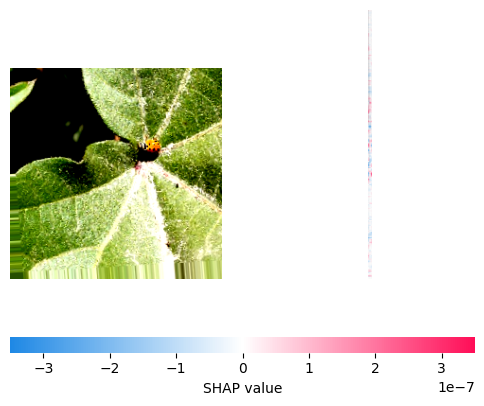

True Label: Lady beetle


In [27]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# ---------------------------
# Step 1: Prepare test dataset for ensemble input
# ---------------------------
def prepare_test_for_ensemble(ds):
    return ds.map(lambda x, y: ((x, x, x), y))

test_ds_ensemble = prepare_test_for_ensemble(test_ds)

# ---------------------------
# Step 2: Extract background images for SHAP
# ---------------------------
background_images = []
for (x1, _, _), _ in test_ds_ensemble.take(10):  # take more batches for better background
    background_images.append(x1.numpy())
background_images = np.concatenate(background_images, axis=0)
background_images = background_images[:100]  # limit to 100 samples

# ---------------------------
# Step 3: Define ensemble prediction function
# ---------------------------
def ensemble_predict_for_shap(images):
    inputs = [images, images, images]
    preds = ensemble_model.predict(inputs)
    return preds

# ---------------------------
# Step 4: Create SHAP explainer
# ---------------------------
explainer = shap.GradientExplainer(ensemble_model, [background_images] * 3)

# ---------------------------
# Step 5: Select a test image for explanation
# ---------------------------
for (batch_x1, batch_x2, batch_x3), batch_y in test_ds_ensemble.take(1):
    test_images = batch_x1[0:1].numpy()  # shape (1, H, W, C)
    true_label = np.argmax(batch_y[0].numpy())
    break

# ---------------------------
# Step 6: Compute SHAP values
# ---------------------------
shap_values_raw = explainer.shap_values([test_images, test_images, test_images])  # 3 inputs → 7 class outputs

# ---------------------------
# Step 7: Aggregate SHAP values from the 3 inputs (ensemble)
# ---------------------------
# shap_values_raw shape: [3][7][1, H, W, C] => convert to [7][1, H, W, C]
shap_values = []
num_classes = len(shap_values_raw[0])
for class_idx in range(num_classes):
    sum_shap = np.sum([
        shap_values_raw[0][class_idx],
        shap_values_raw[1][class_idx],
        shap_values_raw[2][class_idx]
    ], axis=0)
    shap_values.append(sum_shap)

# ---------------------------
# Step 8: Visualize SHAP image explanations for all classes
# ---------------------------
print(f"Showing SHAP heatmaps for all {num_classes} classes")
shap.image_plot(shap_values, test_images)

print(f"True Label: {class_names[true_label]}")


2025-07-29 07:49:09.431426: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-29 07:49:09.585074: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-29 07:49:10.617050: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-29 07:49:10.769645: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-29 07:49:11.923984: E external/local_xla/xla/stream_

IndexError: list index out of range

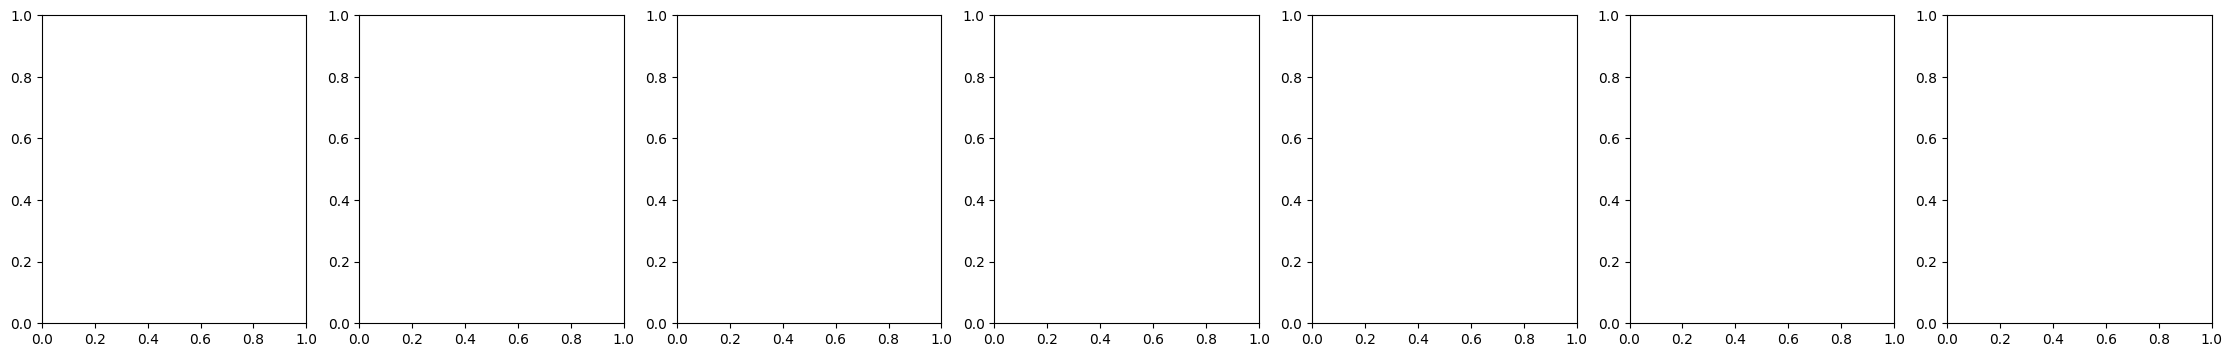

In [30]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Step 1: Prepare test dataset with 3 identical inputs (if not already done)
def prepare_test_for_ensemble(ds):
    return ds.map(lambda x, y: ((x, x, x), y))

test_ds_ensemble = prepare_test_for_ensemble(test_ds)

# Step 2: Extract representative background images from x1 input
background_images = []
for (x1, _, _), _ in test_ds_ensemble.unbatch().take(100):
    background_images.append(x1.numpy())
background_images = np.array(background_images)

# Step 3: Define prediction wrapper for SHAP
def ensemble_predict_for_shap(images):
    # Replicate input across all 3 ensemble branches
    input_batch = [images, images, images]
    return ensemble_model.predict(input_batch)

# Step 4: Initialize SHAP explainer
explainer = shap.GradientExplainer(ensemble_model, [background_images]*3)

# Step 5: Show SHAP explanations for 7 classes using one test image
for (x1_batch, _, _), y_batch in test_ds_ensemble.take(1):
    test_image = x1_batch[0:1].numpy()   # Shape: (1, 224, 224, 3)
    true_label = np.argmax(y_batch[0].numpy())
    break

# Step 6: Compute SHAP values for the test image
shap_values = explainer.shap_values([test_image]*3)

# Step 7: Visualize SHAP for all classes
num_classes = len(shap_values)
fig, axes = plt.subplots(1, num_classes, figsize=(4 * num_classes, 4))

for i in range(num_classes):
    # shap_values[i][0] shape: (224, 224, 3)
    heatmap = shap_values[i][0]
    img_to_plot = test_image[0]  # Shape: (224, 224, 3)

    axes[i].imshow((img_to_plot * 0.5 + 0.5))  # Normalize to [0,1] range
    axes[i].imshow(heatmap, cmap='jet', alpha=0.5)
    axes[i].set_title(f"Class: {class_names[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print(f"True Label: {class_names[true_label]}")


In [29]:
import numpy as np
from sklearn.model_selection import KFold

# Step 1: Extract all images and labels from tf.data.Dataset (e.g., train_ds_full)
images = []
labels = []

for img_batch, label_batch in train_ds_full:  # <-- use your dataset name here
    images.extend(img_batch.numpy())
    labels.extend(label_batch.numpy())

X = np.array(images)
y = np.array(labels)

# Step 2: Optional — convert one-hot labels to categorical if needed
if y.ndim == 2:  # one-hot encoded
    y = np.argmax(y, axis=1)

# Now X and y are ready for K-Fold
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


NameError: name 'train_ds_full' is not defined

In [ ]:
from sklearn.preprocessing import label_binarize

# Binarize y_true and y_pred for ROC
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
y_pred_bin = y_pred_probs  # Already probabilities

# Compute macro ROC AUC
roc_auc = roc_auc_score(y_true_bin, y_pred_bin, average="macro")
print(f"Macro-average ROC AUC: {roc_auc:.3f}")


In [ ]:
plt.figure(figsize=(8,4))
plt.plot(val_acc_per_fold, label='Validation Accuracy')
plt.plot(val_loss_per_fold, label='Validation Loss')
plt.title('Validation Accuracy and Loss across Folds')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()
